# Lesson 1 - What's your pet

Welcome to lesson 1! For those of you who are using a Jupyter Notebook for the first time, you can learn about this useful tool in a tutorial we prepared specially for you; click `File`->`Open` now and click `notebook_tutorial.ipynb`. 

In this lesson we will build our first image classifier from scratch, and see if we can achieve world-class results. Let's dive in!

Every notebook starts with the following three lines; they ensure that any edits to libraries you make are reloaded here automatically, and also that any charts or images displayed are shown in this notebook.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

We import all the necessary packages. We are going to work with the [fastai V1 library](http://www.fast.ai/2018/10/02/fastai-ai/) which sits on top of [Pytorch 1.0](https://hackernoon.com/pytorch-1-0-468332ba5163). The fastai library provides many useful functions that enable us to quickly and easily build neural networks and train our models.

In [2]:
from fastai import *
from fastai.vision import *

If you're using a computer with an unusually small GPU, you may get an out of memory error when running this notebook. If this happens, click Kernel->Restart, uncomment the 2nd line below to use a smaller *batch size* (you'll learn all about what this means during the course), and try again.

In [3]:
bs = 64
# bs = 16   # uncomment this line if you run out of memory even after clicking Kernel->Restart

## Looking at the data

We are going to use the [Oxford-IIIT Pet Dataset](http://www.robots.ox.ac.uk/~vgg/data/pets/) by [O. M. Parkhi et al., 2012](http://www.robots.ox.ac.uk/~vgg/publications/2012/parkhi12a/parkhi12a.pdf) which features 12 cat breeds and 25 dogs breeds. Our model will need to learn to differentiate between these 37 distinct categories. According to their paper, the best accuracy they could get in 2012 was 59.21%, using a complex model that was specific to pet detection, with separate "Image", "Head", and "Body" models for the pet photos. Let's see how accurate we can be using deep learning!

We are going to use the `untar_data` function to which we must pass a URL as an argument and which will download and extract the data.

In [ ]:
help(untar_data)

Help on function untar_data in module fastai.datasets:

untar_data(url:str, fname:Union[pathlib.Path, str]=None, dest:Union[pathlib.Path, str]=None, data=True)
    Download `url` if doesn't exist to `fname` and un-tgz to folder `dest`



In [4]:
path = untar_data(URLs.PETS); path

PosixPath('/home/jupyter/.fastai/data/oxford-iiit-pet')

In [ ]:
path.ls()

[PosixPath('/data1/jhoward/git/course-v3/nbs/dl1/data/oxford-iiit-pet/annotations'),
 PosixPath('/data1/jhoward/git/course-v3/nbs/dl1/data/oxford-iiit-pet/images')]

In [6]:
path_anno = path/'annotations'
path_img = path/'images'

The first thing we do when we approach a problem is to take a look at the data. We _always_ need to understand very well what the problem is and what the data looks like before we can figure out how to solve it. Taking a look at the data means understanding how the data directories are structured, what the labels are and what some sample images look like.

The main difference between the handling of image classification datasets is the way labels are stored. In this particular dataset, labels are stored in the filenames themselves. We will need to extract them to be able to classify the images into the correct categories. Fortunately, the fastai library has a handy function made exactly for this, `ImageDataBunch.from_name_re` gets the labels from the filenames using a [regular expression](https://docs.python.org/3.6/library/re.html).

In [7]:
fnames = get_image_files(path_img)
fnames[:5]

[PosixPath('/home/jupyter/.fastai/data/oxford-iiit-pet/images/pomeranian_27.jpg'),
 PosixPath('/home/jupyter/.fastai/data/oxford-iiit-pet/images/Maine_Coon_7.jpg'),
 PosixPath('/home/jupyter/.fastai/data/oxford-iiit-pet/images/newfoundland_29.jpg'),
 PosixPath('/home/jupyter/.fastai/data/oxford-iiit-pet/images/shiba_inu_135.jpg'),
 PosixPath('/home/jupyter/.fastai/data/oxford-iiit-pet/images/Maine_Coon_192.jpg')]

In [8]:
np.random.seed(2)
pat = r'/([^/]+)_\d+.jpg$'

In [9]:
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(), size=224, bs=bs)
data.normalize(imagenet_stats)

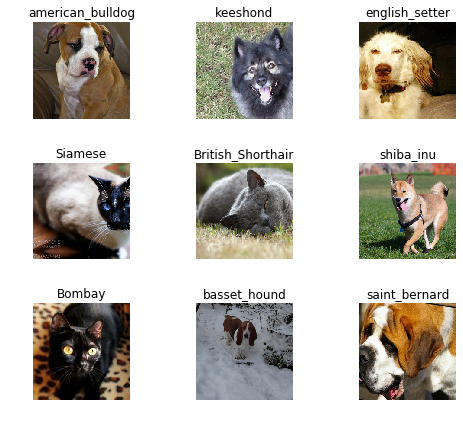

In [ ]:
data.show_batch(rows=3, figsize=(7,6))

In [ ]:
print(data.classes)
len(data.classes),data.c

['american_bulldog', 'german_shorthaired', 'japanese_chin', 'great_pyrenees', 'Bombay', 'Bengal', 'keeshond', 'shiba_inu', 'Sphynx', 'boxer', 'english_cocker_spaniel', 'american_pit_bull_terrier', 'Birman', 'basset_hound', 'British_Shorthair', 'leonberger', 'Abyssinian', 'wheaten_terrier', 'scottish_terrier', 'Maine_Coon', 'saint_bernard', 'newfoundland', 'yorkshire_terrier', 'Persian', 'havanese', 'pug', 'miniature_pinscher', 'Russian_Blue', 'staffordshire_bull_terrier', 'beagle', 'Siamese', 'samoyed', 'chihuahua', 'Egyptian_Mau', 'Ragdoll', 'pomeranian', 'english_setter']


(37, 37)

## Training: resnet34

Now we will start training our model. We will use a [convolutional neural network](http://cs231n.github.io/convolutional-networks/) backbone and a fully connected head with a single hidden layer as a classifier. Don't know what these things mean? Not to worry, we will dive deeper in the coming lessons. For the moment you need to know that we are building a model which will take images as input and will output the predicted probability for each of the categories (in this case, it will have 37 outputs).

We will train for 4 epochs (4 cycles through all our data).

In [11]:
learn = ConvLearner(data, models.resnet34, metrics=error_rate)

In [12]:
learn.fit_one_cycle(1)

Total time: 00:39
epoch  train_loss  valid_loss  error_rate
1      0.821182    0.280010    0.081836    (00:39)



In [ ]:
learn.save('stage-1')

## Results

Let's see what results we have got. 

We will first see which were the categories that the model most confused with one another. We will try to see if what the model predicted was reasonable or not. In this case the mistakes look reasonable (none of the mistakes seems obviously naive). This is an indicator that our classifier is working correctly. 

Furthermore, when we plot the confusion matrix, we can see that the distribution is heavily skewed: the model makes the same mistakes over and over again but it rarely confuses other categories. This suggests that it just finds it difficult to distinguish some specific categories between each other; this is normal behaviour.

In [13]:
interp = ClassificationInterpretation.from_learner(learn)

In [39]:
def my_plot_top_losses(self, k, largest=True, figsize=(12,12)):
        "Show images in `top_losses` along with their prediction, actual, loss, and probability of actual class."
        tl_val,tl_idx = self.top_losses(k,largest)
        classes = self.data.classes
        rows = math.ceil(math.sqrt(k))
        fig,axes = plt.subplots(rows,rows,figsize=figsize)
        plt.subplots_adjust(hspace=0.6)
        for i,idx in enumerate(tl_idx):
            t=self.data.valid_ds[idx]
            t[0].show(ax=axes.flat[i], title=
                f'Prediction: {classes[self.pred_class[idx]]} \n Actual: {classes[t[1]]} \n Loss: {self.losses[idx]:.2f} \n Probability: {self.probs[idx][t[1]]:.2f}')


In [40]:
interp.plot_top_losses = my_plot_top_losses

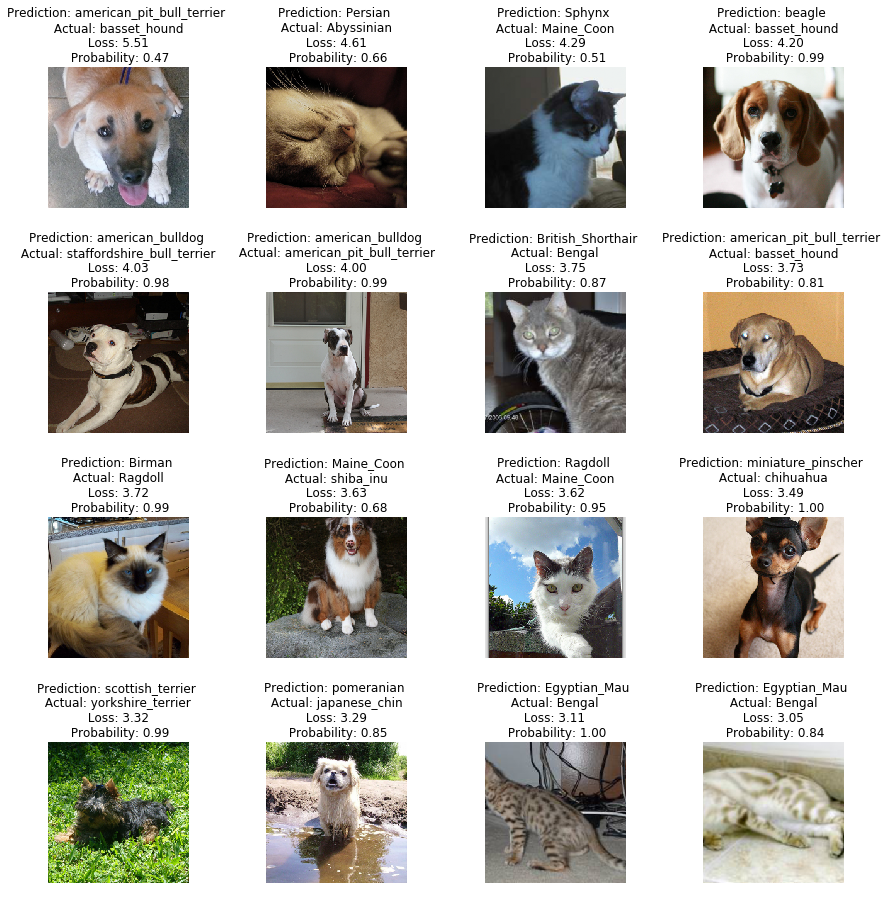

In [48]:
interp.plot_top_losses(interp, 16, figsize=(15,15))

In [ ]:
doc(interp.plot_top_losses)

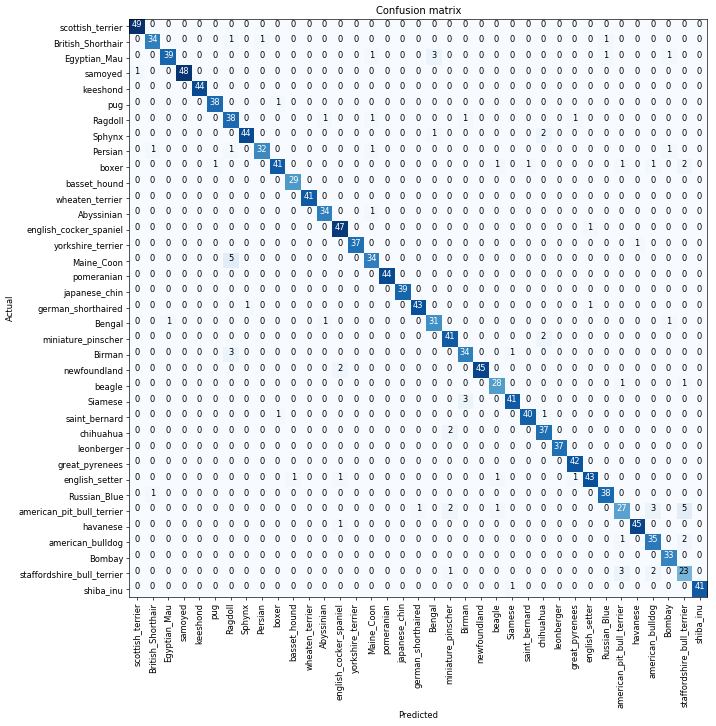

In [ ]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [ ]:
interp.most_confused(min_val=2)

[('Maine_Coon', 'Ragdoll', 5),
 ('american_pit_bull_terrier', 'staffordshire_bull_terrier', 5),
 ('Egyptian_Mau', 'Bengal', 3),
 ('Birman', 'Ragdoll', 3),
 ('Siamese', 'Birman', 3),
 ('american_pit_bull_terrier', 'american_bulldog', 3),
 ('staffordshire_bull_terrier', 'american_pit_bull_terrier', 3)]

## Unfreezing, fine-tuning, and learning rates

Since our model is working as we expect it to, we will *unfreeze* our model and train some more.

In [ ]:
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(1)

Total time: 00:21
epoch  train loss  valid loss  error_rate
0      1.017550    0.566690    0.185629    (00:21)



In [ ]:
learn.load('stage-1')

In [ ]:
learn.lr_find()

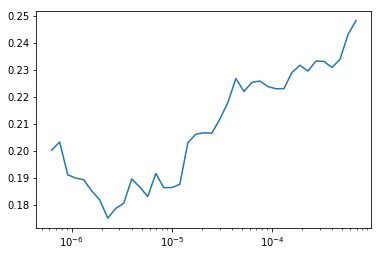

In [ ]:
learn.recorder.plot()

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

Total time: 00:42
epoch  train loss  valid loss  error_rate
1      0.200614    0.176755    0.057219    (00:21)
2      0.197669    0.169028    0.053892    (00:20)



That's a pretty accurate model!

## Training: resnet50

Now we will train in the same way as before but with one caveat: instead of using resnet34 as our backbone we will use resnet50 (resnet34 is a 34 layer residual network while resnet50 has 50 layers. Later in the course you can learn the details in the [resnet paper](https://arxiv.org/pdf/1512.03385.pdf)).

Basically, resnet50 usually performs better because it is a deeper network with more parameters. Let's see if we can achieve a higher performance here. To help it along, let's us larger images too, since that way the network can see more detail. We reduce the batch size a bit since otherwise this larger network might eat up our GPU memory.

In [ ]:
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(), size=320, bs=bs//2)
data.normalize(imagenet_stats)

In [ ]:
learn = Learner.create_cnn(data, models.resnet50, metrics=error_rate)

In [ ]:
learn.fit_one_cycle(8, max_lr=slice(1e-3))

Total time: 07:08
epoch  train_loss  valid_loss  error_rate
1      0.926640    0.320040    0.076555    (00:52)
2      0.394781    0.205191    0.063568    (00:52)
3      0.307754    0.203281    0.069036    (00:53)
4      0.244182    0.160488    0.054682    (00:53)
5      0.185785    0.153520    0.049214    (00:53)
6      0.157732    0.149660    0.047163    (00:53)
7      0.107212    0.136898    0.043062    (00:53)
8      0.097324    0.136638    0.042379    (00:54)



In [ ]:
learn.save('stage-1-50')

It's astonishing that it's possible to recognize pet breeds so accurately! Let's see if full fine-tuning helps:

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(3, max_lr=slice(1e-6,1e-4))

Total time: 03:34
epoch  train_loss  valid_loss  error_rate
1      0.106340    0.142091    0.041695    (01:10)
2      0.087324    0.143114    0.045796    (01:11)
3      0.074554    0.136358    0.043062    (01:11)



In this case it doesn't, so let's go back to our previous model.

In [ ]:
learn.load('stage-1-50')

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

In [ ]:
interp.most_confused(min_val=2)

[('Ragdoll', 'Birman', 7),
 ('american_pit_bull_terrier', 'staffordshire_bull_terrier', 6),
 ('Egyptian_Mau', 'Bengal', 6),
 ('Maine_Coon', 'Bengal', 3),
 ('staffordshire_bull_terrier', 'american_pit_bull_terrier', 3)]

## Other data formats

In [ ]:
path = untar_data(URLs.MNIST_SAMPLE); path

PosixPath('/home/jhoward/.fastai/data/mnist_sample')

In [ ]:
tfms = get_transforms(do_flip=False)
data = ImageDataBunch.from_folder(path, ds_tfms=tfms, size=26)

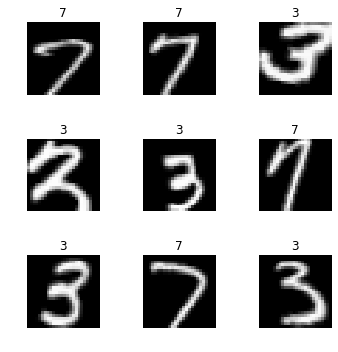

In [ ]:
data.show_batch(rows=3, figsize=(5,5))

In [ ]:
learn = Learner.create_cnn(data, models.resnet18, metrics=accuracy)
learn.fit(2)

Total time: 00:11
epoch  train loss  valid loss  accuracy
1      0.108823    0.025363    0.991168  (00:05)
2      0.061547    0.020443    0.994112  (00:05)



In [ ]:
df = pd.read_csv(path/'labels.csv')
df.head()

,name,label
0,train/3/7463.png,0
1,train/3/21102.png,0
2,train/3/31559.png,0
3,train/3/46882.png,0
4,train/3/26209.png,0


In [ ]:
data = ImageDataBunch.from_csv(path, ds_tfms=tfms, size=28)

[0, 1]

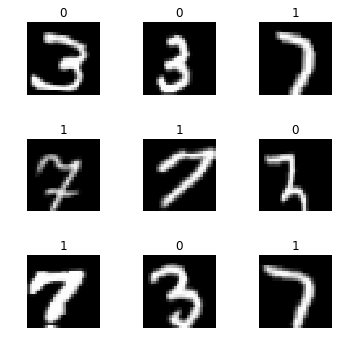

In [ ]:
data.show_batch(rows=3, figsize=(5,5))
data.classes

In [ ]:
data = ImageDataBunch.from_df(path, df, ds_tfms=tfms, size=24)
data.classes

[0, 1]

In [ ]:
fn_paths = [path/name for name in df['name']]; fn_paths[:2]

[PosixPath('/home/jhoward/.fastai/data/mnist_sample/train/3/7463.png'),
 PosixPath('/home/jhoward/.fastai/data/mnist_sample/train/3/21102.png')]

In [ ]:
pat = r"/(\d)/\d+\.png$"
data = ImageDataBunch.from_name_re(path, fn_paths, pat=pat, ds_tfms=tfms, size=24)
data.classes

['3', '7']

In [ ]:
data = ImageDataBunch.from_name_func(path, fn_paths, ds_tfms=tfms, size=24,
        label_func = lambda x: '3' if '/3/' in str(x) else '7')
data.classes

['3', '7']

In [ ]:
labels = [('3' if '/3/' in str(x) else '7') for x in fn_paths]
labels[:5]

['3', '3', '3', '3', '3']

In [ ]:
data = ImageDataBunch.from_lists(path, fn_paths, labels=labels, ds_tfms=tfms, size=24)
data.classes

['3', '7']